In [23]:
import timm
import torch
import numpy as np
import pandas as pd
import random
from pathlib import Path
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from typing import Callable, Optional
from torch.utils.data import DataLoader, Dataset
from torch import nn
import cv2
from dataclasses import dataclass


# Classification dataset

{'n02089973': 0, '.DS_Store': 1, 'n02086240': 2, 'n02105641': 3, 'n02087394': 4, 'n02099601': 5, 'n02115641': 6, 'n02093754': 7, 'n02111889': 8, 'n02096294': 9, 'n02088364': 10}


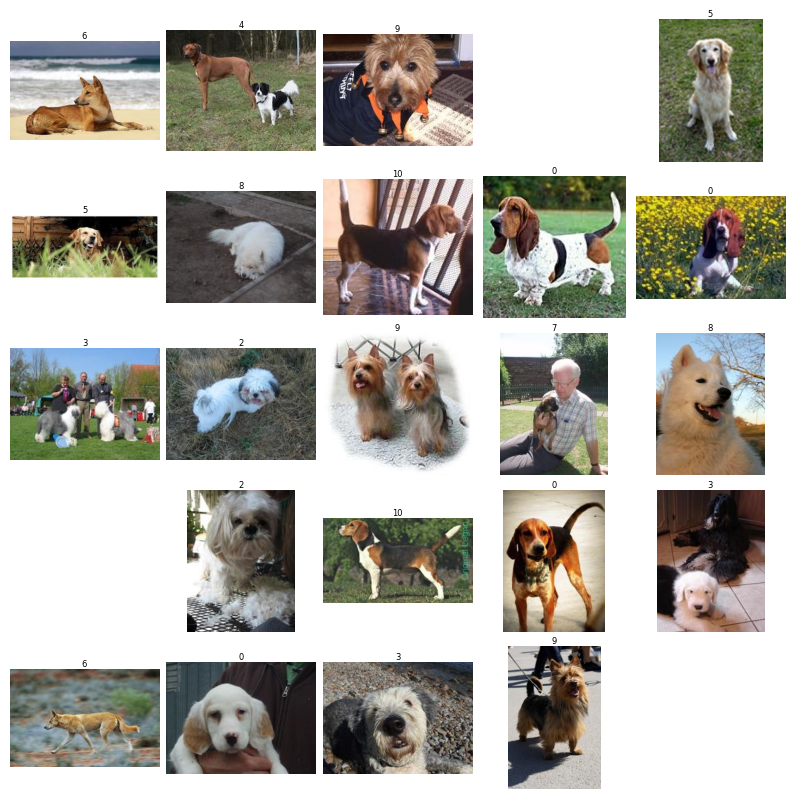

In [7]:
dataset_name = ['imagewoof-160']
train_path = Path('/Users/jeremyong/Desktop/research_agent/dataset/imagewoof-160/train')
classes = {file_name.name: index for index, file_name in enumerate(train_path.iterdir())}
print(classes)
class_folders = list(train_path.iterdir())

num_height, num_width = 5, 5
fig, ax = plt.subplots(num_height, num_width, figsize=(10, 10))

for i in range(num_height):
    for j in range(num_width):
        # Randomly select a class folder
        class_folder = random.choice(class_folders)
        image_files = list(class_folder.glob('*.JPEG')) + list(class_folder.glob('*.jpg'))
        
        if len(image_files) > 0:
            # Randomly select an image
            img_path = random.choice(image_files)
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i, j].imshow(img)
            ax[i, j].set_title(classes[class_folder.name], fontsize=6, pad=2)
        
        ax[i, j].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Minimize spacing
plt.show()

# Dataset

In [11]:
class ImageWoofDataset(Dataset):
    def __init__(self, data_dir: Path, transform: Optional[Callable] = None):
        self.data_dir = data_dir
        self.transform = transform
        
        # Get class folders (excluding .DS_Store)
        self.class_folders = sorted([d for d in data_dir.iterdir() 
                                     if d.is_dir() and d.name != '.DS_Store'])
        
        # Create class name to index mapping
        self.classes = {folder.name: idx for idx, folder in enumerate(self.class_folders)}
        
        # Collect all image paths with their labels
        self.samples = []
        for class_folder in self.class_folders:
            class_idx = self.classes[class_folder.name]
            # Find all JPEG/jpg images in this class folder
            image_files = list(class_folder.glob('*.JPEG')) + list(class_folder.glob('*.jpg'))
            for img_path in image_files:
                self.samples.append((img_path, class_idx))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        
        # Read image
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Model configuration

In [12]:
@dataclass
class ModelConfig:
    model_name: str = 'tinynet_e.in1k'
    pretrained: bool = False
    num_classes: int = 11
    learning_rate: float = 1e-4
    weight_decay: float = 1e-4
    
config = ModelConfig()


# Model

In [18]:
class ClassificationModel(pl.LightningModule):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.save_hyperparameters()
        
        # Model setup
        self.model = timm.create_model(
            config.model_name, 
            pretrained=config.pretrained, 
            num_classes=config.num_classes
        )
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = config.learning_rate
        self.weight_decay = config.weight_decay

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        # Calculate accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        # Calculate accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay
        )
        
        # Add learning rate scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=self.trainer.max_epochs
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }
    
    

In [ ]:
# Initialize model with config
config = ModelConfig(
    model_name='tinynet_e.in1k',
    num_classes=10,
    learning_rate=1e-3,
    weight_decay=0.01,
    pretrained=True
)

model = ClassificationModel(config)

# Create dataloaders separately (NOT in the model)
train_path = Path('/Users/jeremyong/Desktop/research_agent/dataset/imagewoof-160/train')
val_path = Path('/Users/jeremyong/Desktop/research_agent/dataset/imagewoof-160/val')

train_dataset = ImageWoofDataset(train_path)
val_dataset = ImageWoofDataset(val_path)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# Train
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='auto',
    devices=1,
    callbacks=[
        ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=3)
    ]
)

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | EfficientNet     | 774 K  | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
774 K     Trainable params
0         Non-trainable params
774 K     Total params
3.099     Total estimated model params size (MB)
218       Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/research_agent_env/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/research_agent_env/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/research_agent_env/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/research_agent_env/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'ImageWoofDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
    self = reduction.pickl

RuntimeError: DataLoader worker (pid(s) 57133, 57134) exited unexpectedly

# Training

In [ ]:
# 